In [3]:
from time import time

import numpy as np
import pandas as pd
import sklearn.metrics as sk_metrics
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from torch.utils.data import random_split
from matplotlib import pyplot as plt
from nam.wrapper import NAMClassifier, MultiTaskNAMClassifier

In [4]:
def make_gender_mtl_data(X, y):
    y_male = y.copy()
    y_male[X['sex'] == 1] = np.nan
    y_female = y.copy()
    y_female[X['sex'] == 0] = np.nan
    return pd.concat([y_female, y_male], axis=1)

def onehot_pos_embedding(x):
    onehot = np.zeros((x.shape[-1], x.shape[-1]))
    for i in range(6):
        onehot[i, i] = 1
    onehot = np.repeat(onehot[np.newaxis, :, :], x.shape[0], axis=0)
    return np.concatenate((x[:, :, np.newaxis], onehot), axis=2)


In [5]:
pre_train_path = None

random_state = 2016
dataset = pd.read_csv('nam/data/recid.data', delimiter=' ', header=None)
dataset.columns = ["age", "race", "sex", "priors_count", "length_of_stay", "c_charge_degree", "two_year_recid"]
binary = ['sex', 'c_charge_degree']
other = ['age', 'race', 'priors_count', 'length_of_stay']
# scaler = MinMaxScaler((-1, 1))
# dataset[other] = scaler.fit_transform(dataset[other])
dataset[binary] = dataset[binary] - 1

X_data = dataset.drop(columns=['two_year_recid']).to_numpy()
y_data = dataset['two_year_recid'].to_numpy().reshape(-1, 1)
X_data = onehot_pos_embedding(X_data)
print(X_data.shape)

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, train_size=0.8, test_size=0.2, random_state=random_state)

#Single Task NAMs Classification
s_time = time()
model = NAMClassifier(
    num_epochs=1000,
    lr=0.001,

    num_learners=20,
    metric='auroc',
    early_stop_mode='max',
    monitor_loss=False,
    n_jobs=10,
    random_state=random_state,
    device='cuda:0',
    pos_embed=1,
)
    

(6172, 6, 7)


In [6]:
model.fit(X_train, y_train)

Format converting and model initializing are done.


2022-12-13 20:26:25.940984: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [7]:
pred, feature, feature_after_att, attn_output_weights = model.predict_proba(X_test)

In [8]:
print(sk_metrics.roc_auc_score(y_test, pred))

0.7483392294024427


In [9]:

feature_after_att = feature_after_att.detach().numpy()
pred = np.squeeze(pred).tolist()

In [10]:
X_test=X_test[:, :, 0]

In [11]:
X_test

array([[28.,  3.,  1.,  0.,  1.,  0.],
       [40.,  1.,  1., 15., 55.,  0.],
       [31.,  1.,  1.,  0.,  0.,  0.],
       ...,
       [45.,  3.,  1.,  1.,  1.,  1.],
       [25.,  3.,  1.,  3., 19.,  0.],
       [34.,  3.,  1.,  1.,  3.,  0.]])

In [72]:
def plot_fig(j, x_label):
    
    curr_data_list = []
    for i in range(len(X_test)):
        curr_data_list.append(X_test[i][j])
    X = curr_data_list
    Y = pred
    Z = y_test.squeeze().tolist()

    df = pd.DataFrame(list(zip(X, Y, Z)),
               columns =['val', 'pred', 'gt'])
    df
    if j==0:
        averaged = df.groupby(pd.cut(df["val"], np.arange(18, 90, 5))).mean()
        averaged.reset_index(drop=True, inplace=True)
    elif j==3:
        averaged = df.groupby(pd.cut(df["val"], np.arange(0, 33, 5))).mean()
        averaged.reset_index(drop=True, inplace=True)
    elif j==4:
        averaged = df.groupby(pd.cut(df["val"], np.arange(0, 600, 20))).mean()
        averaged.reset_index(drop=True, inplace=True)
    else:
        averaged = df.groupby('val').mean()
        averaged['val'] = averaged.index


    X = averaged["val"].tolist()
    Y = averaged["pred"].tolist()
    Z = averaged["gt"].tolist()
    print(X)
    if j == 0:
        plt.xlim([20,70])
    if j == 4:
        plt.xlim([0,250])
    plt.ylim([-0.2,1.2])
    plt.xlabel(x_label) 
    plt.ylabel('Recudivism probability (Pred/GT)') 
    plt.plot(X, Y)
    plt.plot(X, Z)
    
    

[21.582159624413144, 25.76140350877193, 30.829596412556054, 35.79054054054054, 40.82022471910113, 45.98979591836735, 50.921052631578945, 55.758620689655174, 60.72, 65.71428571428571, 70.0, 77.0, 81.0, nan]


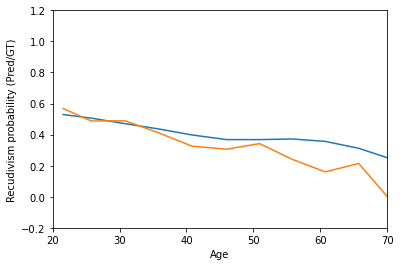

In [73]:
plot_fig(0, "Age")

[1.0, 2.0, 3.0, 4.0, 5.0, 6.0]


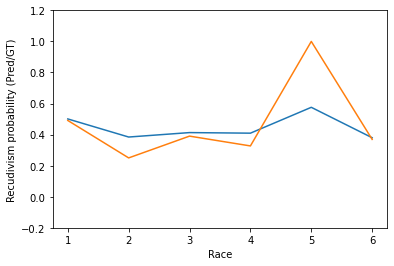

In [74]:
plot_fig(1, "Race")

[0.0, 1.0]


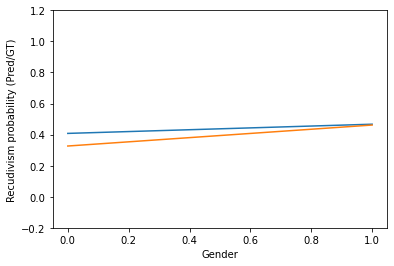

In [75]:
plot_fig(2, "Gender")

[2.274914089347079, 7.604651162790698, 13.016949152542374, 17.545454545454547, 22.833333333333332, 28.0]


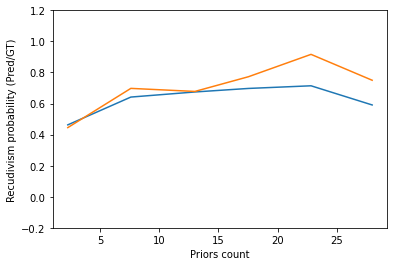

In [76]:
# priors_count
plot_fig(3, "Priors count")

[2.727574750830565, 29.742424242424242, 49.27777777777778, 69.875, 86.41666666666667, 112.8, 131.28571428571428, 148.0, 172.0, 188.0, 216.0, 239.0, 242.0, 280.0, nan, 301.0, nan, nan, nan, nan, nan, nan, nan, 470.0, nan, nan, nan, nan, nan]


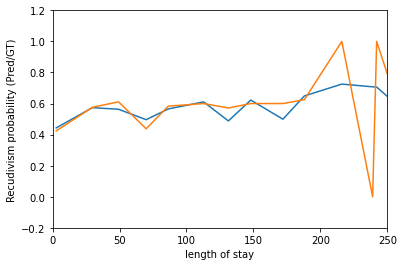

In [77]:

plot_fig(4, 'length of stay')

[0.0, 1.0]


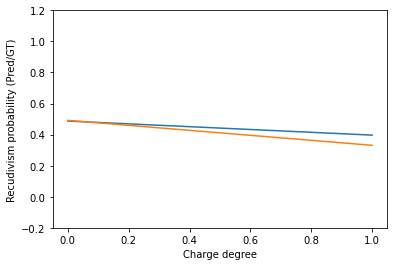

In [78]:
plot_fig(5, 'Charge degree')


In [70]:
dict = {"pred": pred, "feature":feature, "feature_after_att": feature_after_att, "attn_output_weights":attn_output_weights, "X": X_test, "gt": y_test.squeeze()}

In [71]:
import csv
with open('recid_data.csv', 'w', newline='') as f:
    writer = csv.DictWriter(f, fieldnames=dict.keys())
    writer.writeheader()
    writer.writerow(dict)